<a href="https://colab.research.google.com/github/kashish-vaish/dev-platform/blob/main/Visual_Segmentation/Using_Meta_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3wf8lktw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3wf8lktw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=11e03abe7239876788c35da0cdf069a8e07341a6f7eea311e6e4d34fc575d900
  Stored in directory: /tmp/pip-ephem-wheel-cache-ndjx0udn/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
pip install -q roboflow supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00


In [4]:
import urllib
urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth', "sam_vit_h_4b8939.pth")

('sam_vit_h_4b8939.pth', <http.client.HTTPMessage at 0x7c60cf3b4370>)

In [7]:
import os
print(os.path.join(os.getcwd(),"sam_vit_h_4b8939.pth"))
CHECKPOINT_PATH = os.path.join(os.getcwd(),"sam_vit_h_4b8939.pth")

/content/sam_vit_h_4b8939.pth


In [8]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [11]:
urllib.request.urlretrieve("https://media.roboflow.com/notebooks/examples/dog-4.jpeg","dog-4.jpeg")

('dog-4.jpeg', <http.client.HTTPMessage at 0x7c5fcb7db280>)

In [12]:
import cv2
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)
IMAGE_PATH = os.path.join(os.getcwd(),"dog-4.jpeg")
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

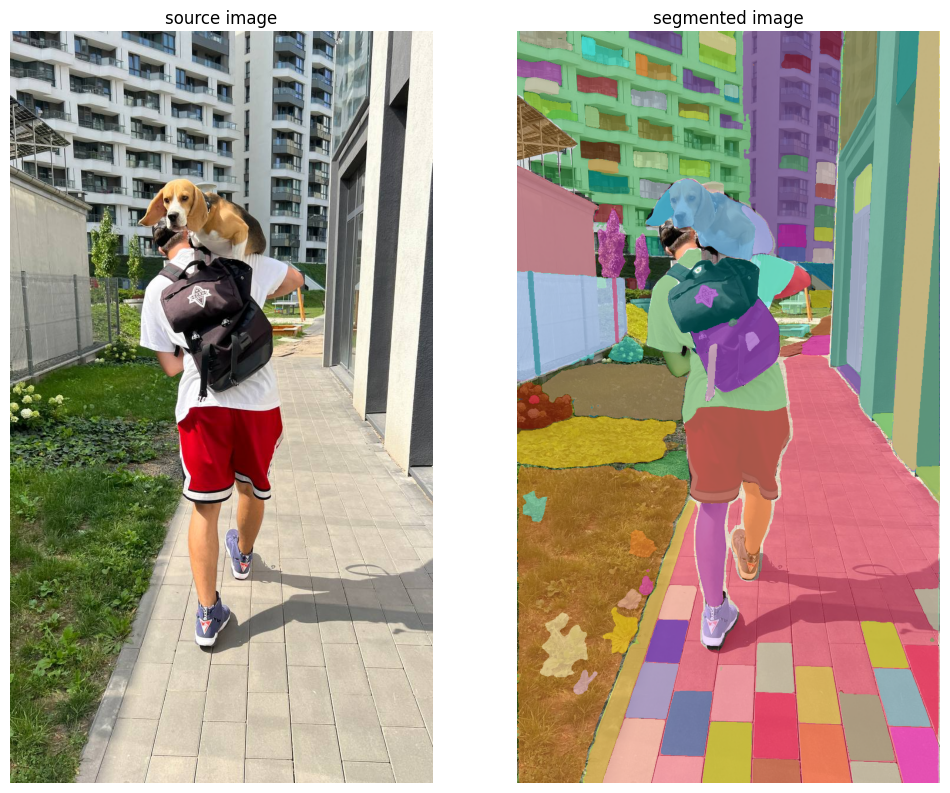

In [14]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(result)
annotated_image = mask_annotator.annotate(image_bgr, detections)
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(result, key=lambda x: x['area'], reverse=True)
]
#print(len(masks))
#I used number 18 as the len of masks was 146, so factored it in to decide 18
sv.plot_images_grid(
    images=masks,
    grid_size=(18, int(len(masks) / 8)),
    size=(18, 18)
)

In [23]:
urllib.request.urlretrieve("https://media.roboflow.com/notebooks/examples/dog.jpeg","dog.jpeg")

('dog.jpeg', <http.client.HTTPMessage at 0x7c5f67e9ce80>)

In [25]:
import numpy as np

box = np.array([68, 247, 623, 925])

In [26]:
import numpy as np
import supervision as sv
import cv2
from segment_anything import SamPredictor

mask_predictor = SamPredictor(sam)

IMAGE_PATH = os.path.join(os.getcwd(),"dog.jpeg")
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

box = np.array([70, 247, 626, 926])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

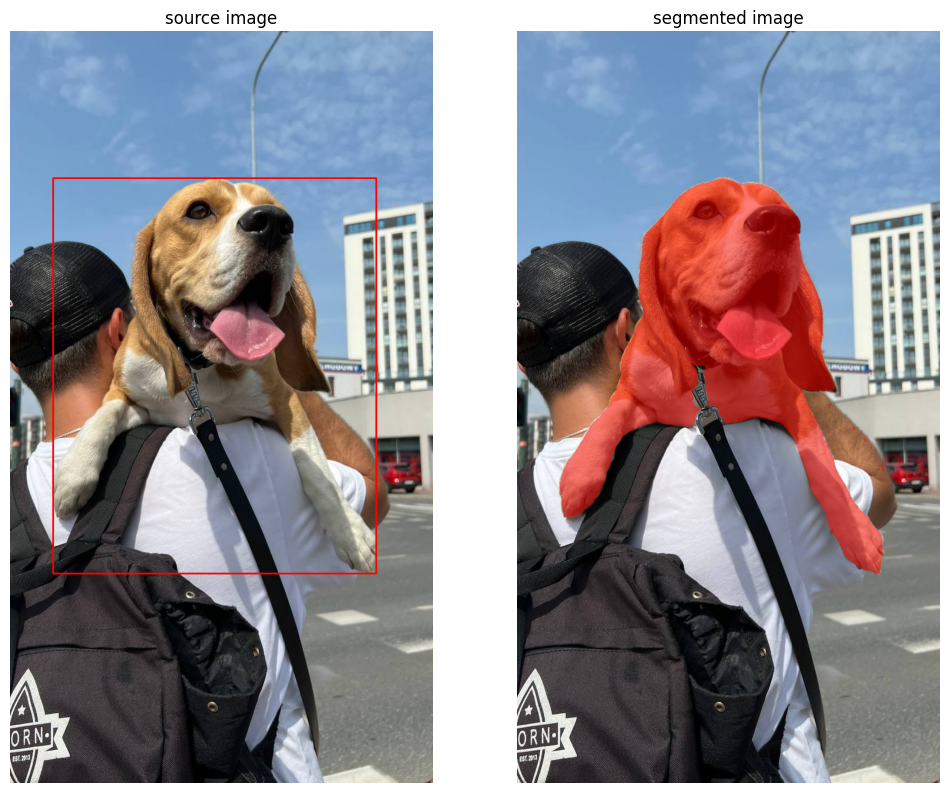

In [27]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)